In [1]:
import os
import sys
import glob
import scipy
import skbio
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('white')
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import display, HTML
import tRep

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 200

### NOTE ON THIS VERSION

This version does a minor adjustment on the top15 most abundant virus figure --> remove all phages; remove SF and SQ samples.

### Load relevant tables

In [2]:
Ndb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/Wastewater_DeltaCoverage_All_Viral_Genomes_v2b_SetMinBreadth.csv')
Ndb_raw = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/Wastewater_DeltaCoverage_All_Viral_Genomes_v2_AddRelativeAbundance.csv')
RMdb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/Wastewater_ReadMapping_All_Viral_Genomes_v1.csv')

Gdb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/metadata/viral_name_df.csv')
Rdb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/waster_water_readDepths_formatted.csv')
Mdb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/metadata/sample_metadata_v2_sample_name_adjusted.csv')

In [3]:
Ndb.head(2)

,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,6383.0,0.116825,0.436002,0.950337,6107540,82174,1.000000,0.995833,48,67,0.974626,1.0,136,0.003333,1.0,1.0,0,1.602238,0.020378,0.037600,0.567921,0.0,NaN,False,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,1.591744,0.936806,13.321758,6107540,82174,0.999802,0.999207,654,743,0.990614,33.0,1524,0.004306,1.0,1.0,11,11.393603,0.144792,0.788675,0.999992,0.0,1.607168,False,20.0,7.95,0.515256,0.97197,4.0,1.0,1.0,32.0


### Remove all phage scaffolds & SF+San Quentin samples

In [38]:
# check number of phage scaffolds

print(len(Ndb[Ndb['genome'].str.contains('phage')]['genome'].unique()))

46

In [54]:
Mdb_SF_SQ = Mdb[Mdb['location'].isin(['SanQuentin ','SF '])]
Mdb_SF_SQ_samples = Mdb_SF_SQ['sample'].unique().tolist()
len(Mdb_SF_SQ_samples)

7

In [55]:
# check number of SF & San Quentin samples

print(len(Ndb[Ndb['sample'].isin(Mdb_SF_SQ_samples)]['sample'].unique()))

7


In [57]:
Ndb_no_phage_genomes = Ndb[-Ndb['genome'].str.contains('phage')]
Ndb_no_SQ_SF_samples = Ndb_no_phage_genomes[-Ndb_no_phage_genomes['sample'].isin(Mdb_SF_SQ_samples)]

print(len(Ndb_no_SQ_SF_samples['sample'].unique()))
print(len(Ndb_no_phage_genomes['sample'].unique()))
print(len(Ndb['sample'].unique()))
print()
print(len(Ndb_no_SQ_SF_samples['genome'].unique()))
print(len(Ndb_no_phage_genomes['genome'].unique()))
print(len(Ndb['genome'].unique()))

27
34
34

75
85
131


In [58]:
sample2core = dict(zip(Ndb['sample'],Ndb['core']))
sample2description = dict(zip(Ndb['sample'],Ndb['sample_complete_description']))
sample2enrichment = dict(zip(Ndb['sample'],Ndb['enrichment']))
sample2method = dict(zip(Ndb['sample'],Ndb['method']))
sample2subgroup = dict(zip(Ndb['sample'],Ndb['subgroup']))

### plot abundance

In [67]:
from cycler import cycler

def simple_stacks_v5(data, x, y, hue, palette = False, size = (5, 3), \
                    xlim = False, ylim = False, xtitle='', ytitle='',\
                    width = 0.75, title='', save=False, order=False, xorder=False):
    """
    plot stacked bar chart
    * v5 = allow to use this function to do subplots
    """

    # legend
    plt.legend(loc='best', prop = {'size': 10})
    
    
    if order == False:
        df = data[data['relative_abundance (%)'] > 0]
        # order to plot each item based on most abundant first
        items = set(df[hue]) # all hues (genomes)
        items = [(sum([i for i in df[df[hue] == s][y].values\
                       if type(i) is float]), s) for s in items] # (sum of values, hue)
        items = [i[1] for i in sorted(items, reverse = True)] # hues ordered by sum
    else:
        df = data[data['relative_abundance (%)'] > 0]
        assert set(order) == set(df[hue])
        assert len(set(order)) == len(order)
        items = order

        
    # values
    if xorder == False:
        X_labels = sorted(list(set(data[x]))) # All x labels
    else:
        assert set(xorder) == set(data[x])
        X_labels = xorder
    X = list(range(0, len(X_labels))) # range of x labels

    # count data for plotting
    running = [0 for i in X]
    Iabundance = [] # [hue, [sum(hue) for every x + previous hues], [sum(hue) for every x ]]
    for s in items:
        hdb = data[data[hue] == s] # dataframe with only this hue (s)
        abundance = [] # list of the abundance of values for this hue
        for xi in X_labels:
            a = np.nan_to_num(hdb[hdb[x] == xi][y].values) # all values of this hue + x
            if len(a) == 0:
                abundance.append(0)
            else:
                a = [i for i in a if type(i) is not str]
                abundance.append(np.nansum(a)) # append all values

        running = [i + j for i, j in zip(running, abundance)] # this hue + all previous hues
        Iabundance.append([s, running, abundance])

    # plot abundance
    for s, running, abundance in Iabundance[::-1]:
#         s = hue, running = [sum(x) + previous for x in hue]
        if palette == False:
            plt.rc('axes', prop_cycle=cycler('color', colors))
            
            ax.bar(X, running, \
                   label = s,\
                   width = width, alpha = 1, linewidth=0)
        else:
            ax.bar(X, running, \
                    label = s, color = palette[s],\
                    width = width, alpha = 1, linewidth=0)
    ax.set_xticks([xi for xi in X])
    ax.set_xticklabels(X_labels,rotation=90)
    
#     plt.xticks([xi for xi in X], X_labels,rotation=90)
#     ax.set_xticklabels([xi for xi in X], X_labels, rotation=90)

    # legend
#     plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.8), \
#             prop = {'size': 10, 'style': 'italic'})

    # ylim
    if ylim != False:
        plt.ylim(0,ylim)

    # xlim
    plt.xlim(-1, len(X_labels))

    # title
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    # save
    if save != False:
        plt.savefig(str(save) + ".svg",format="svg",transparent=True, bbox_inches='tight')

### Plot top15 most abundant viral genomes

In [68]:
table = defaultdict(list)
for g,gdb in Ndb_no_SQ_SF_samples.groupby('genome'):
    total_relative_abundance_sum = gdb['relative_abundance (%)'].sum()
    
    table['genome'].append(g)
    table['total_relative_abundance'].append(total_relative_abundance_sum)
    
Sdb = pd.DataFrame(table).sort_values('total_relative_abundance',ascending=False).reset_index(drop=True)
Sdb_top15 = Sdb.head(15)
print(len(Sdb))
print(len(Ndb_no_SQ_SF_samples['genome'].unique()))
Sdb_top15

75
75


,genome,total_relative_abundance
0,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,30.244295
1,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,22.902051
2,Cucumber_green_mottle_mosaic_virus_strain_SH-tax12235-GCF_000849225.1_ViralProj14681_genomic.fna,2.602401
3,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,1.398741
4,Human_bocavirus_3_strain_W471-tax638313-GCF_000882855.1_ViralProj37291_genomic.fna,1.396343
5,Human_bocavirus_2c_PK-tax1511882-GCF_000882675.1_ViralProj33891_genomic.fna,1.316658
6,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,0.774635
7,Wuhan_insect_virus_23_strain_WHCCII13263-tax1923727-GCF_001921615.1_ViralMultiSegProj358547_genomic.fna,0.078965
8,Hubei_picorna_like_virus_61_strain_mosHB235903-tax1923144-GCF_001957495.1_ViralProj361635_genomic.fna,0.078741
9,Tropical_soda_apple_mosaic_virus-tax327387-GCF_001654245.1_ViralProj322841_genomic.fna,0.068303


In [69]:
Ndb4 = Ndb_no_SQ_SF_samples.copy()
Ndb4['genome'] = [x if x in Sdb_top15['genome'].tolist() else 'Other viruses' for x in Ndb4['genome']]
Ndb4 = Ndb4.reset_index(drop=True)
print(len(Ndb4['genome'].unique()))
Ndb4

16


,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,6383.0,0.116825,0.436002,0.950337,6107540,82174,1.000000,0.995833,48,67,0.974626,1.0,136,0.003333,1.0,1.0,0,1.602238,0.020378,0.037600,0.567921,0.000000,NaN,False,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,1.591744,0.936806,13.321758,6107540,82174,0.999802,0.999207,654,743,0.990614,33.0,1524,0.004306,1.0,1.0,11,11.393603,0.144792,0.788675,0.999992,0.000000,1.607168,False,20.0,7.950000,0.515256,0.971970,4.0,1.0,1.0,32.0
2,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,1.445713,0.704979,2.508344,6107540,82174,0.999827,0.999482,594,662,0.988274,8.0,1377,0.004077,1.0,1.0,1,3.323712,0.019285,0.193860,0.890832,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,1.0,1.0,7.0
3,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,6357.0,0.058413,0.339626,0.495989,6107540,82174,0.000000,0.000000,24,30,0.974398,0.0,61,NaN,1.0,1.0,0,0.776961,0.009903,0.000000,0.354647,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Cucumber_green_mottle_mosaic_virus_strain_SH-tax12235-GCF_000849225.1_ViralProj14681_genomic.fna,6424.0,0.029206,0.149440,0.259496,6107540,82174,1.000000,1.000000,12,13,0.981476,0.0,26,0.000000,1.0,1.0,0,0.770032,0.009761,0.008095,0.204779,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,pS68-1,pS68-1_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,6357.0,0.005764,0.884222,11.430234,1273909514,17384174,0.996229,0.990153,501,634,0.987072,129.0,1579,0.011531,1.0,1.0,10,8.767478,0.111744,0.750826,0.999959,0.000000,1.151338,False,38.0,21.710526,0.448116,1.000000,47.0,18.0,18.0,111.0
417,pS68-1,pS68-1_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Picalivirus_A-tax1224515-GCF_004128835.1_ASM412883v1_genomic.fna,8966.0,0.000828,0.292327,1.169306,1273909514,17384174,0.986680,0.984631,72,80,0.982705,16.0,192,0.001685,1.0,1.0,0,2.498078,0.026683,0.108856,0.643884,0.000000,NaN,False,NaN,NaN,NaN,NaN,15.0,13.0,13.0,3.0
418,pS68-1,pS68-1_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Other viruses,13385.0,0.000909,0.149570,0.856556,1273909514,17384174,0.999131,0.999131,79,82,0.997104,1.0,174,0.000000,3.0,3.0,0,2.626386,0.023229,0.085992,0.530618,0.000000,NaN,False,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0
419,pS68-1,pS68-1_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Hubei_picorna_like_virus_61_strain_mosHB235903-tax1923144-GCF_001957495.1_ViralProj361635_genomic.fna,8681.0,0.000196,0.111853,0.290865,1273909514,17384174,0.969925,0.969925,17,35,0.958324,4.0,109,0.000000,1.0,1.0,0,0.993983,0.010794,0.015321,0.226503,0.000000,NaN,False,NaN,NaN,NaN,NaN,4.0,4.0,4.0,0.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


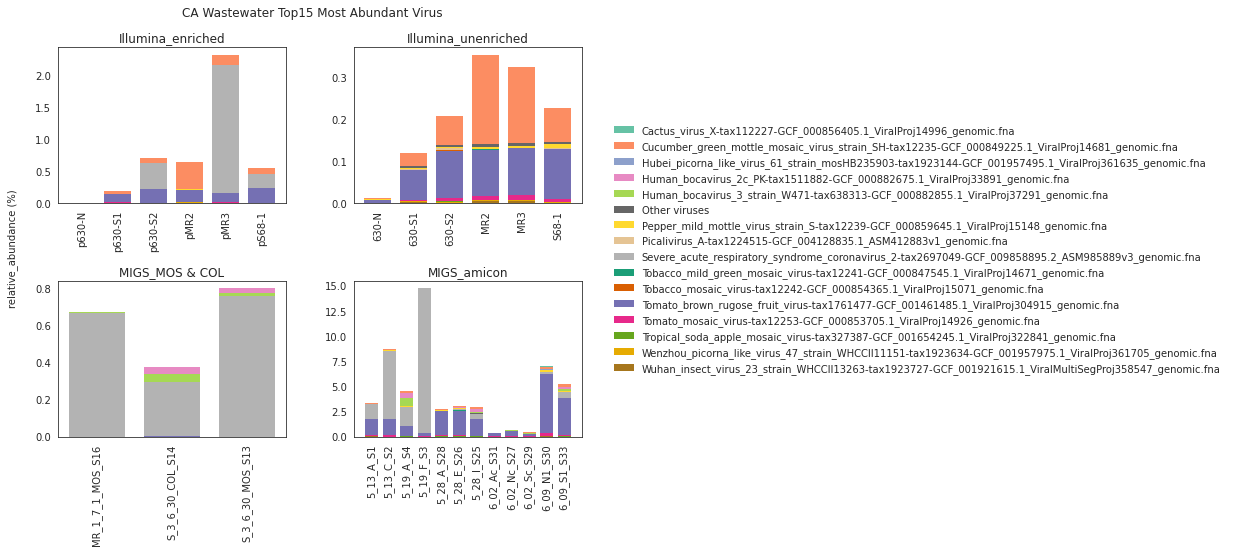

In [70]:
colors_top15 = []
for i,c in enumerate(plt.get_cmap('Set2').colors):
    colors_top15.append(c)
for i,c in enumerate(plt.get_cmap('Dark2').colors):
    colors_top15.append(c)

genome2color_top15 = dict(zip(Sdb_top15.sort_values('genome')['genome'].tolist()+['Other viruses'], colors_top15))

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.5,wspace = 0.3)
fig.suptitle('CA Wastewater Top15 Most Abundant Virus',y=1.06)

for (name, sgdb), ax in zip(Ndb4.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name), palette=genome2color_top15,size=(10,3))

    ax.set(title=name)
ax.get_legend().remove()

handles = []
labels = []
for ax in fig.axes:
    axHandles, axLabels = ax.get_legend_handles_labels()
    handles.extend(axHandles)
    labels.extend(axLabels)
by_label = dict(zip(labels, handles))

from collections import OrderedDict
by_label_sorted = OrderedDict(sorted(by_label.items())) 
fig.legend(by_label_sorted.values(), by_label_sorted.keys(), loc='center left',bbox_to_anchor=(1.05, 0.7),frameon=False)

fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');
plt.savefig('/groups/banfield/projects/human/data3/clou/wastewater/Figure/CA_Wastewater_Top15_Most_Abundant_Virus_v2_no_phages_no_SF_SQ_samples.svg',\
            format='svg',transparent=True,bbox_inches='tight')